In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']=""

In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50, MobileNetV2
from keras.applications.vgg16 import preprocess_input
#from keras.applications.mobilenetv2 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import pandas as pd
from PIL import Image

# Train and Test data

In [4]:
train_path = "dataset\\train"
test_path = "dataset\\test"

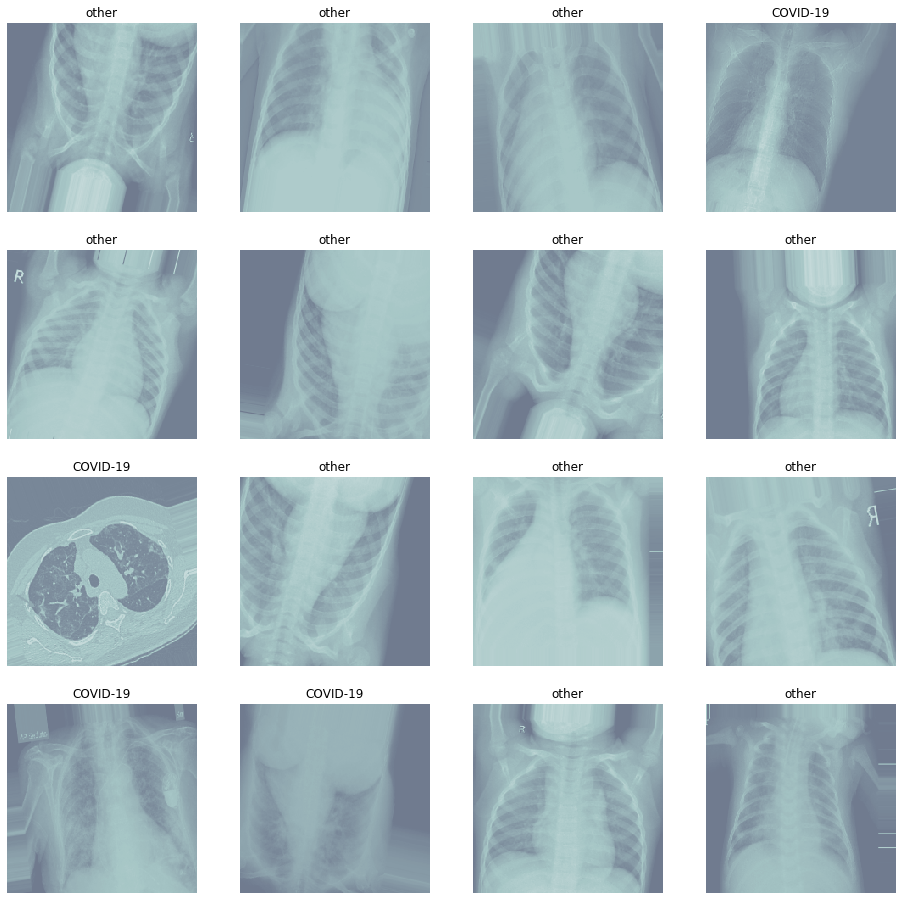

In [9]:
all_labels = ['COVID-19','other']
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Creating Train and Test Data Generators

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
 rotation_range=20,
 featurewise_center = True,
 featurewise_std_normalization = True,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.25,
 zoom_range=0.1,
 zca_whitening = True,
 channel_shift_range = 20,
 horizontal_flip = True ,
 vertical_flip = True ,
 validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

d:\anaconda\envs\tf_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [6]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (224, 224),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 318 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


# Using Transfer learning and downloading the weights of VGG16

In [232]:
basemodel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# Adding additional layers and Building the model

In [245]:
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
#headModel = Dense(256, activation="relu")(headModel)
#headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [246]:
model = Model(inputs=basemodel.input, outputs=headModel)

In [247]:
for layer in basemodel.layers:
    layer.trainable = False

# Model parameters, compiling and Training

In [248]:
epochs= 80
lr = 1e-4
BS = 16

In [249]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4,decay=lr/epochs),metrics=["accuracy"])

In [250]:
#history = model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=BS),steps_per_epoch=len(X_train) // BS,validation_data=(X_test, Y_test),validation_steps=len(X_test) // BS,epochs=epochs)
model.fit_generator(train_generator,
                    steps_per_epoch = 270//BS,
                    epochs = epochs,
                    validation_data = test_generator,
                    validation_steps = 36//BS)

Epoch 1/80
20/20 [==============================] - 7s 371ms/step - loss: 0.8673 - acc: 0.4403 - val_loss: 0.7087 - val_acc: 0.5625
Epoch 2/80
20/20 [==============================] - 10s 492ms/step - loss: 0.7170 - acc: 0.6006 - val_loss: 0.7136 - val_acc: 0.5625
Epoch 3/80
20/20 [==============================] - 10s 502ms/step - loss: 0.6806 - acc: 0.6195 - val_loss: 0.6713 - val_acc: 0.5833
Epoch 4/80
20/20 [==============================] - 10s 508ms/step - loss: 0.6723 - acc: 0.6101 - val_loss: 0.6364 - val_acc: 0.6042
Epoch 5/80
20/20 [==============================] - 11s 534ms/step - loss: 0.6041 - acc: 0.6761 - val_loss: 0.6355 - val_acc: 0.6042
Epoch 6/80
20/20 [==============================] - 10s 504ms/step - loss: 0.6013 - acc: 0.6761 - val_loss: 0.6121 - val_acc: 0.6250
Epoch 7/80
20/20 [==============================] - 10s 494ms/step - loss: 0.5721 - acc: 0.7201 - val_loss: 0.6088 - val_acc: 0.6250
Epoch 8/80
20/20 [==============================] - 10s 520ms/step - l

Epoch 39/80
20/20 [==============================] - 11s 527ms/step - loss: 0.3740 - acc: 0.8302 - val_loss: 0.3651 - val_acc: 0.8333
Epoch 40/80
20/20 [==============================] - 11s 529ms/step - loss: 0.3864 - acc: 0.8333 - val_loss: 0.3549 - val_acc: 0.8750
Epoch 41/80
20/20 [==============================] - 10s 522ms/step - loss: 0.3567 - acc: 0.8648 - val_loss: 0.3544 - val_acc: 0.8958
Epoch 42/80
20/20 [==============================] - 11s 528ms/step - loss: 0.3734 - acc: 0.8302 - val_loss: 0.3491 - val_acc: 0.8958
Epoch 43/80
20/20 [==============================] - 11s 561ms/step - loss: 0.3892 - acc: 0.8365 - val_loss: 0.3441 - val_acc: 0.8958
Epoch 44/80
20/20 [==============================] - 10s 524ms/step - loss: 0.3775 - acc: 0.8428 - val_loss: 0.3404 - val_acc: 0.8750
Epoch 45/80
20/20 [==============================] - 11s 532ms/step - loss: 0.3430 - acc: 0.8616 - val_loss: 0.3383 - val_acc: 0.8958
Epoch 46/80
20/20 [==============================] - 11s 541ms

# Evaluationg model on Test Data

In [251]:
x = model.evaluate_generator(test_generator,
 steps = np.ceil(len(test_generator) // BS),
 use_multiprocessing = False,
 verbose = 1,
 workers=1
 )

48/48 [==============================] - 1s 26ms/step - loss: 0.2223 - acc: 0.9583


48/48 [==============================] - 1s 26ms/step
Predictions finished
prob:[0.9988726  0.00112744]
COVID-19\kjr-21-e24-g001-l-b.jpg


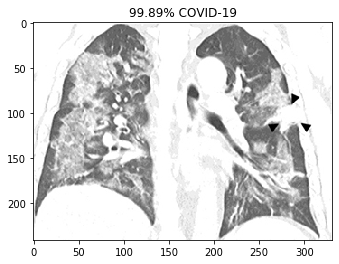

prob:[9.9981135e-01 1.8862003e-04]
COVID-19\kjr-21-e24-g001-l-c.jpg


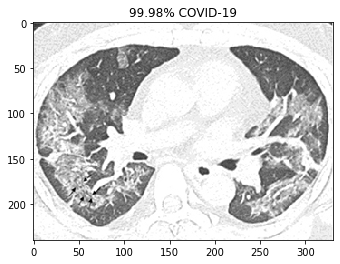

prob:[0.77221835 0.22778164]
COVID-19\kjr-21-e24-g002-l-a.jpg


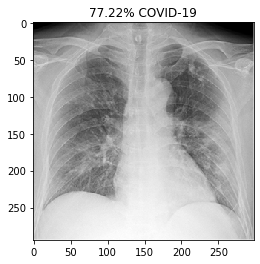

prob:[9.9921763e-01 7.8234175e-04]
COVID-19\kjr-21-e24-g002-l-b.jpg


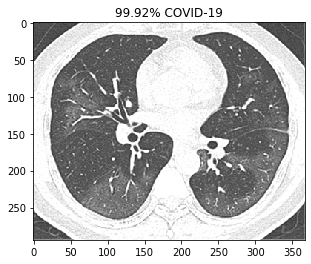

prob:[0.99729913 0.00270093]
COVID-19\kjr-21-e24-g002-l-c.jpg


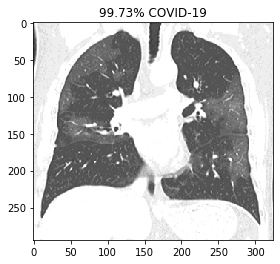

prob:[0.959535   0.04046502]
COVID-19\nCoV-radiol.2020200269.fig1-day7.jpeg


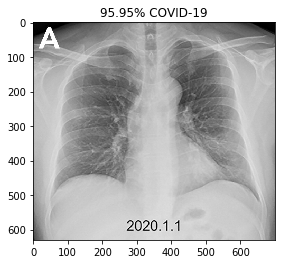

prob:[0.65914804 0.34085196]
COVID-19\nejmc2001573_f1a.jpeg


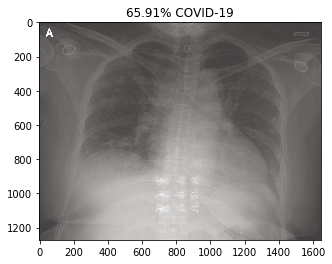

prob:[0.7466953  0.25330466]
COVID-19\nejmc2001573_f1b.jpeg


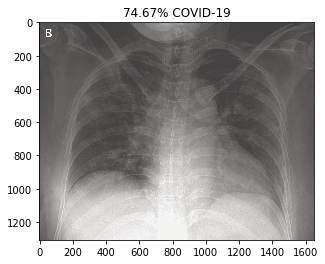

prob:[0.81285655 0.18714342]
COVID-19\nejmoa2001191_f1-L.jpeg


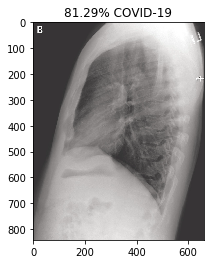

prob:[0.7930669  0.20693305]
COVID-19\nejmoa2001191_f1-PA.jpeg


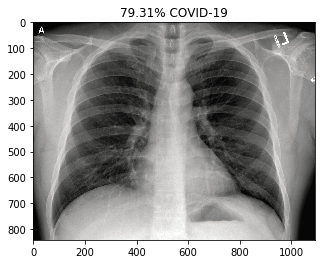

prob:[0.6481045  0.35189557]
COVID-19\nejmoa2001191_f3-L.jpeg


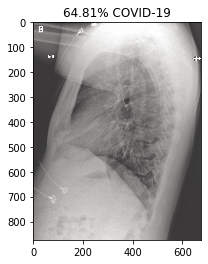

prob:[0.6859937  0.31400636]
COVID-19\nejmoa2001191_f3-PA.jpeg


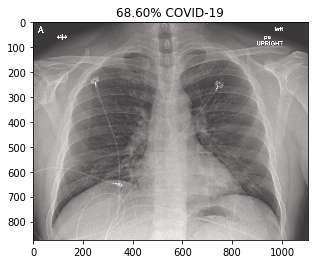

prob:[0.5324108  0.46758923]
COVID-19\nejmoa2001191_f4.jpeg


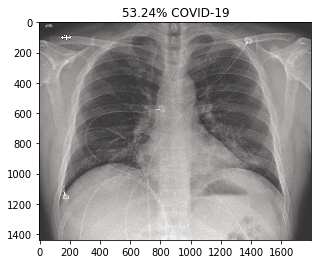

prob:[0.67491937 0.32508063]
COVID-19\nejmoa2001191_f5-L.jpeg


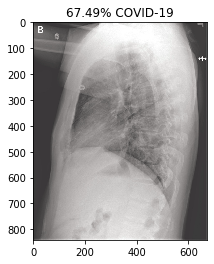

prob:[0.6020115  0.39798844]
COVID-19\nejmoa2001191_f5-PA.jpeg


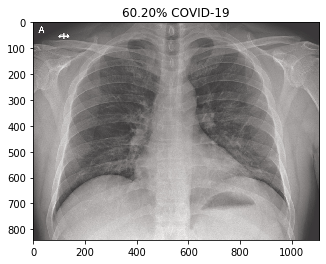

prob:[0.4055436  0.59445643]
COVID-19\radiol.2020200490.fig3.jpeg


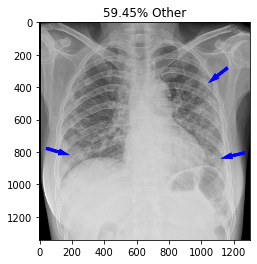

prob:[0.81251675 0.1874833 ]
COVID-19\ryct.2020200028.fig1a.jpeg


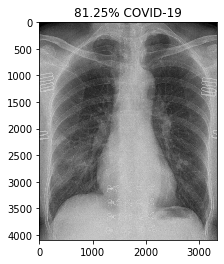

prob:[0.77016085 0.22983919]
COVID-19\ryct.2020200034.fig2.jpeg


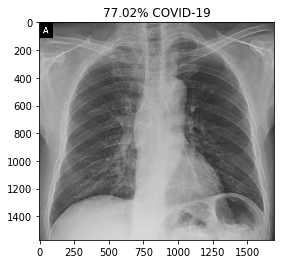

prob:[0.91452193 0.0854781 ]
COVID-19\ryct.2020200034.fig5-day0.jpeg


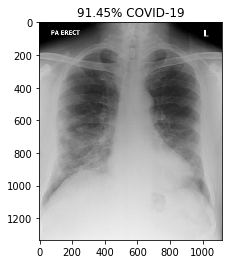

prob:[0.8751303  0.12486966]
COVID-19\ryct.2020200034.fig5-day4.jpeg


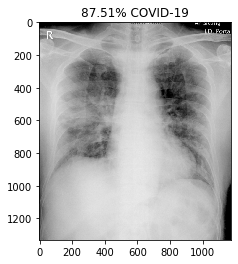

prob:[0.9566615  0.04333853]
COVID-19\ryct.2020200034.fig5-day7.jpeg


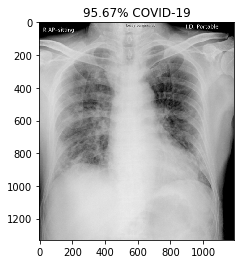

prob:[0.04922089 0.9507791 ]
other\NORMAL2-IM-1385-0001.jpeg


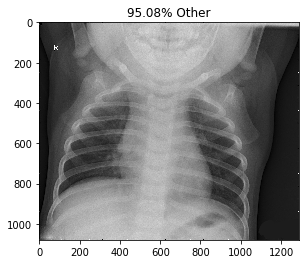

prob:[0.03841791 0.961582  ]
other\NORMAL2-IM-1396-0001.jpeg


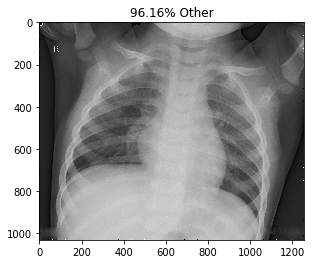

prob:[0.07336457 0.9266354 ]
other\NORMAL2-IM-1400-0001.jpeg


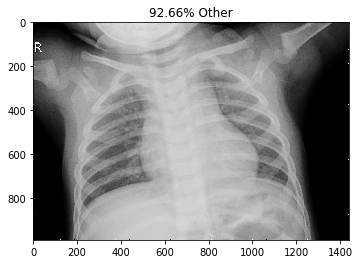

prob:[0.01876921 0.9812308 ]
other\NORMAL2-IM-1401-0001.jpeg


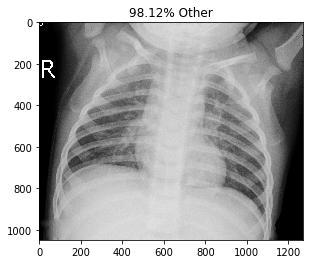

prob:[0.03604348 0.96395653]
other\NORMAL2-IM-1406-0001.jpeg


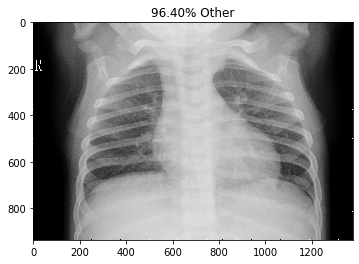

prob:[0.07633305 0.9236669 ]
other\NORMAL2-IM-1412-0001.jpeg


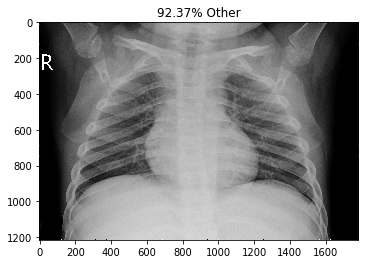

prob:[0.3140168 0.6859832]
other\NORMAL2-IM-1419-0001.jpeg


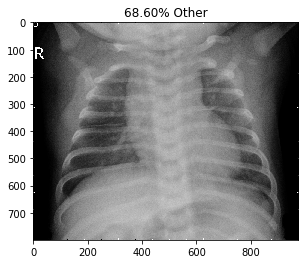

prob:[0.3303995 0.6696005]
other\NORMAL2-IM-1422-0001.jpeg


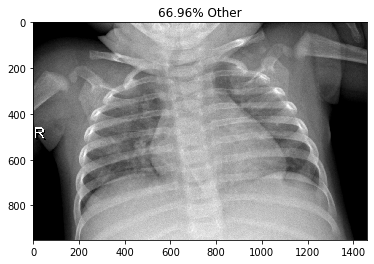

prob:[0.02044783 0.9795522 ]
other\NORMAL2-IM-1423-0001.jpeg


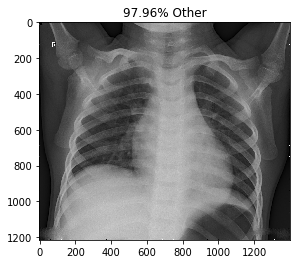

prob:[0.5666914  0.43330857]
other\person1753_bacteria_4594.jpeg


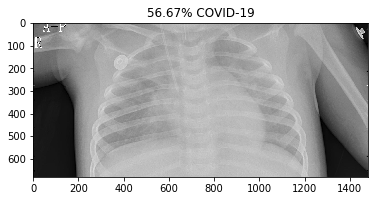

prob:[0.3049889  0.69501114]
other\person1940_bacteria_4859.jpeg


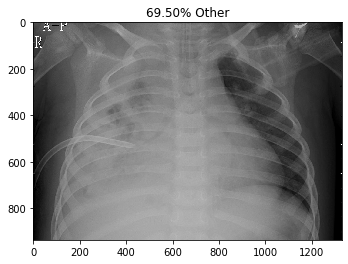

prob:[0.13092026 0.86907977]
other\person1940_bacteria_4861.jpeg


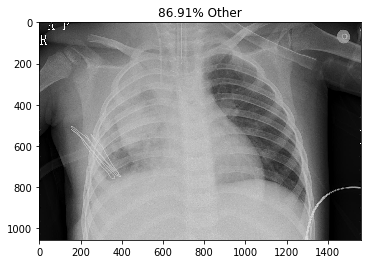

prob:[0.2491806  0.75081944]
other\person1940_bacteria_4862.jpeg


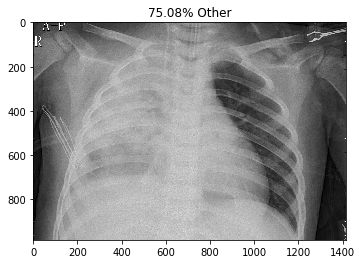

prob:[0.04508393 0.95491606]
other\person1941_bacteria_4863.jpeg


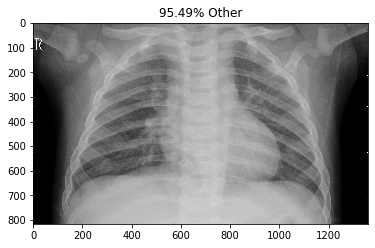

prob:[0.178228   0.82177204]
other\person1942_bacteria_4865.jpeg


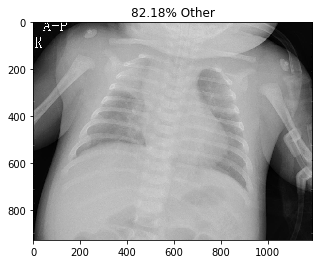

prob:[0.03792105 0.962079  ]
other\person1943_bacteria_4868.jpeg


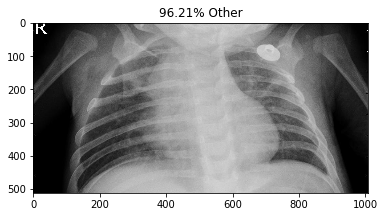

prob:[0.10952864 0.89047134]
other\person1944_bacteria_4869.jpeg


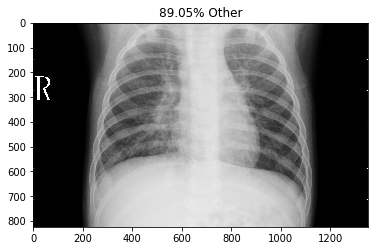

prob:[0.35488835 0.6451116 ]
other\person1945_bacteria_4872.jpeg


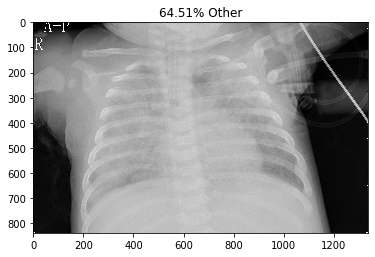

prob:[0.18933608 0.8106639 ]
other\person957_virus_1629.jpeg


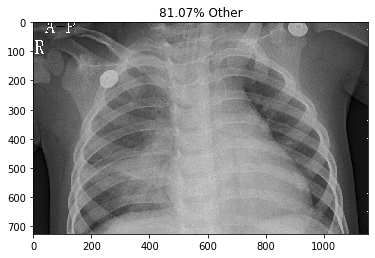

prob:[0.18883722 0.81116277]
other\person958_virus_1630.jpeg


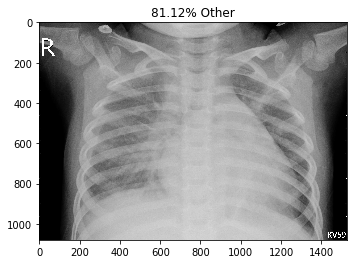

prob:[0.06463908 0.93536097]
other\person960_virus_1633.jpeg


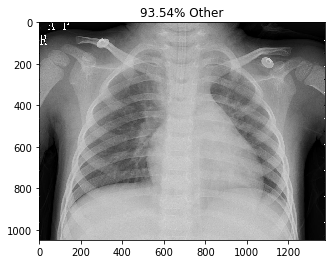

prob:[0.08620565 0.91379434]
other\person961_virus_1634.jpeg


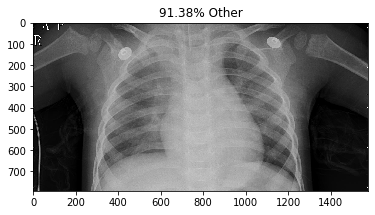

prob:[0.30493423 0.6950658 ]
other\person962_virus_1635.jpeg


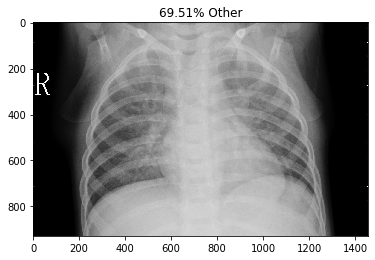

prob:[0.32626754 0.67373246]
other\person963_virus_1636.jpeg


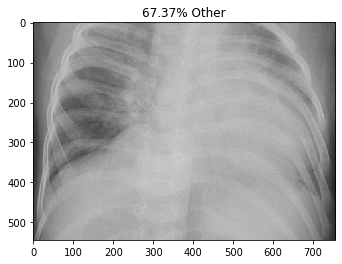

prob:[0.1609018  0.83909816]
other\person964_virus_1637.jpeg


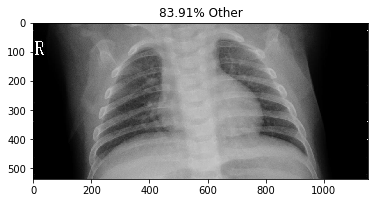

prob:[0.11667891 0.8833211 ]
other\person965_virus_1638.jpeg


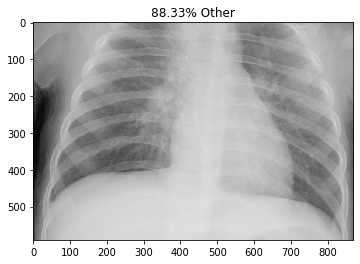

prob:[0.04082768 0.95917225]
other\person966_virus_1639.jpeg


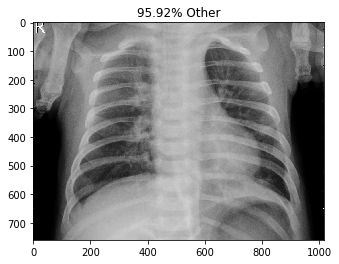

In [267]:
#eval_generator.reset() 
pred = model.predict_generator(test_generator,1000,verbose=1)
print("Predictions finished")
import cv2
import matplotlib.image as mpimg
for index, probability in enumerate(pred):
 image_path = test_path + "/" +test_generator.filenames[index]
 image = mpimg.imread(image_path)
 #BGR TO RGB conversion using CV2
 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 pixels = np.array(image)
 plt.imshow(pixels)
 print("prob:{}".format(probability))
 print(test_generator.filenames[index])
 if probability[1] > 0.5:
     plt.title('%.2f' % (probability[1]*100) + '% Other')
 else:
     plt.title('%.2f' % ((1-probability[1])*100) + '% COVID-19')
 plt.show()

In [253]:
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Test loss: 0.22230163854055718
Test accuracy: 0.9583333


# Loading the saved model for prediction

In [34]:
import keras
from keras.models import load_model
model_ = tf.keras.models.load_model('vgg16_model_95.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [36]:
image_test = Image.open("images/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg").convert('RGB')
image_test = image_test.resize((224,224))
data_test = np.asarray(image_test)
img = np.reshape(data_test,[1,224,224,3])

In [ ]:
plt.imshow(image_test)
model_.predict(img).tolist()
